In [1]:
import numpy as np
import scipy.integrate as spi

import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['font.size'] = 16

This notebook simulates the activity of two neuronal populations that receive each a noisy input. The noisy inputs are generate using a random variable, here a Gaussian (normal) random variable with zero mean and determined by its standard deviation. This corresponds to a stochastic system, as opposed to a deterministic system. This means that each simulation will be specific, in the sense of different from another simaultion, because of the randomness.

As before with the simulation of the activity of a single neuron (leaky integrate and fire, Izhikevich, Hodgkin-Hucley, etc.), we perform the simulation by updating the variables of the system (here the population activities) time step after time step. We use a similar approach for this stochastic system as before with the Euler integration method for a deterministic system. However, a notable difference lies in the rescaling of the time step for the noisy input ($\sqrt{\delta t}$ instead of $\delta t$). For further details, see https://en.wikipedia.org/wiki/Euler%E2%80%93Maruyama_method.

## Simulating a stochastic dynamical system with noise from scratch

Let's consider the input signal $u$ that is a at each time a random normal (Gaussian) variable defined by the same mean and variance. We assume the mean to be zero and the variance to be equal to $\sigma^2$ ($\sigma$ corresponds to variable `s`).

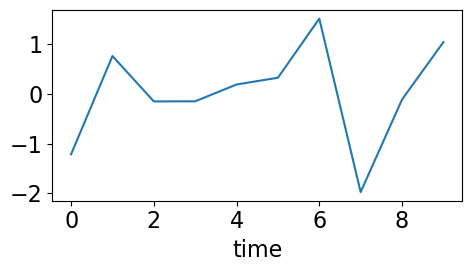

In [2]:
# signal duration and time stamps
n_time = 10
ts = np.arange(n_time)

# noisy input generated using Gaussian (normal) random variable with zero mean and standard deviation s
s = 1.0
u = np.random.randn(n_time) * s

plt.figure(figsize=(5,3))
plt.plot(ts, u)
plt.xlabel('time')
plt.tight_layout()

### Exercise

- check the documentation of `np.random.randn` to simulation 2 noisy inputs of length `n_time`.

Let's now consider a linear system for 2 nodes (each representing a neuronal population) defined by a coupling matrix $J$ and the above time-varying input $u$.
The activities of the two populations is described by the variables $x_1$ and $x_2$, which evolve according to the following equations (Ornstein-Uhlenbeck process):
$$ \frac{{\mathrm {d}} x_1}{{\mathrm {d} }t} = J_{11} x_1 + J_{12} x_2 + u_1^t $$
and
$$ \frac{{\mathrm {d}} x_2}{{\mathrm {d} }t} = J_{11} x_2 + J_{12} x_2 + u_2^t $$
Note that $x_1$, $x_2$, $u_1$ and $u_2$ are functions of time. Note that this is equivalent to the following formulation that uses matrix notation:
$$ \frac{{\mathrm {d}} x}{{\mathrm {d} }t} = + J x + u^t $$

The above equation can be integrated in discrete time using a specific time step $\delta t$ and updating the variables using the Euler-Murayama method with the adjustment of the time step for the stochastic term:
$$ x_1^{t + \delta t} = x_1^{t} + \delta t \, ( J_{11} x_1 + J_{12} x_2 ) + \sqrt{\delta t} \, u_1^t $$
$$ x_2^{t + \delta t} = x_2^{t} + \delta t \, ( J_{21} x_1 + J_{22} x_2 ) + \sqrt{\delta t} \, u_2^t $$

### Exercise

- write a function to perform the numerical integration above
- simulate the Ornstein-Uhlenbeck process and display the activity traces
- calculate the coariance between the simulated time series (https://numpy.org/doc/stable/reference/generated/numpy.cov.html)

In [3]:
def ou(dt, J, u, x_ini):
    '''
    arguments:
        dt: time step
        J: coupling matrix (Jacobian)
            ndarray of shape (n,n)
        u: input
            ndarray of shape (t,n)
        x_ini: initial condition
            ndarray of shape (n)
    return:
        vt: trace for time
        vx: trace for x
    '''
    J = np.asarray(J)
    u = np.asarray(u)

    # get network size n via J and simulation duration t via I
    n_node = J.shape[0]
    n_time = u.shape[0]
    # optional checks
    assert J.shape[0] == J.shape[1], """J should be a square matrix"""
    assert u.shape[1] == J.shape[0], """u should be a matrix with same second dimension as J"""

    # initial conditions for variables x (vector)
    x = np.copy(x_ini)
    # traces for time and x; loop over time stamps
    ts = np.zeros([n_time])
    tx = np.zeros_like(u)
    for it in range(n_time):
        # update traces
        ts[it] = it * dt
        tx[it, :] = x
        # update variables x
        x += dt * np.dot(J, x) + (dt**0.5) * u[it, :]
    # return traces
    return ts, tx

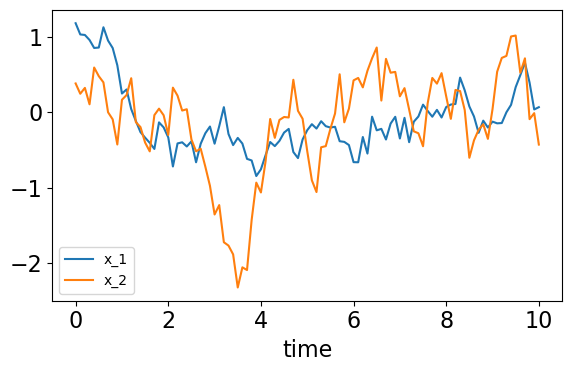

In [4]:
# time stamps
T = 10.0
dt = 0.1

# generate random inputs with variances s1 and s2
s1 = 0.5
s2 = 1.0
u = np.random.randn(int(T/dt)+1,2) * np.array([s1,s2])

# matrix J with a specific weight value from 1 to 0
J = -np.eye(2)
J[0,1] = 0.3

# random initial condition
x_ini = np.random.randn(2)

# simulate network activity
ts, tx = ou(dt, J, u, x_ini)

plt.figure(figsize=(6,4))
plt.plot(ts, tx, label=['x_1','x_2'])
plt.xlabel('time')
plt.legend(fontsize=10)
plt.tight_layout()

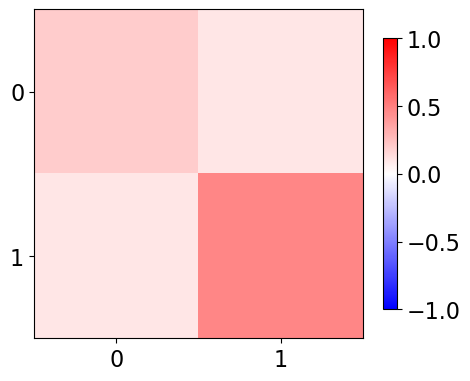

In [5]:
# calculate covariance
cov = np.cov(tx, rowvar=False)

plt.figure(figsize=(5,5))
plt.imshow(cov, vmin=-1.0, vmax=1.0, cmap='bwr')
plt.colorbar(shrink=0.6)
plt.xticks(range(2))
plt.yticks(range(2))
plt.tight_layout()

# Quantifying the influence of the coupling on the covariance measure

### Exercise

- repeat the simulation and calculate the covariance for each sample simulation
- evaluate the influence of the activity covariance with respect to a parameter (i.e. an element of the couplign matrix)
- plot the histogram of several samples for two classes that differ by the Jacobian

In [6]:
n = 100 # sample number
n_node = 2 # node number TRY 4, 6...

# X = matrix of features, y = vector of labels
X = np.zeros([n,1])
y = np.zeros([n])

for i in range(n):
    # labels y for 2 classes depending on Jacobian J
    if i<n/2:
        J = -np.eye(n_node)
        J[0,1] = 0.2 # positive weight for coupling from node 1 to node 0
        y[i] = 0
    else:
        J = -np.eye(n_node)
        J[0,1] = -0.2 # negative weight for coupling from node 1 to node 0
        y[i] = 1
    # initial condition
    if True:
        # random
        x_ini = np.random.randn(n_node)
    else:
        # fixed
        x_ini = np.zeros([n_node])
    # run simulation
    ts, tx = ou(dt, J, u, x_ini)
    # calculate covariance on simulated activity, store the cross-covariance
    X[i,0] = np.cov(tx, rowvar=False)[0,1]

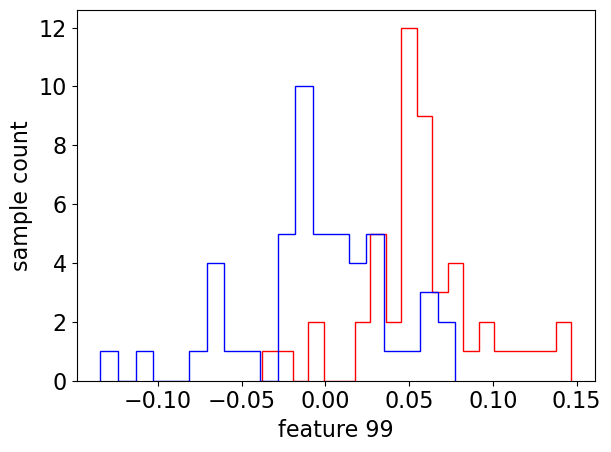

In [7]:
plt.figure()
plt.hist(X[y==0,0], color='r', bins=20, histtype='step')
plt.hist(X[y==1,0], color='b', bins=20, histtype='step')
plt.xlabel(f'feature {i}')
plt.ylabel('sample count')
plt.tight_layout()

By increasing the number of samples `n`, you can better appreciate the difference between the distribution (red and blue for simulations in two conditions).

By switching the boolean `True` with `False` above (see code after `# initial condition`, you can run the code with a fixed initial condition instead of a random one. You can thus see the effect of the initial condition on the calculated covariance.

By changing the value of the coupling weight from `0.2` to larger values (try `0.5`, `0.8`, etc.), you can see the distributions becoming more disctinct from one another.